In [1]:
%matplotlib inline
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from lxml import etree
from mxnet import image, nd
from skimage.transform import resize


In [2]:
input_height=224
input_width=224

PATH_TO_ROOT = str(Path.cwd().parent)
# parameters that you should set before running this script
filter = ['aeroplane', 'cat']       # select class, this default should yield 1489 training and 1470 validation images
voc_root_folder = PATH_TO_ROOT + "/data/VOCdevkit/" 
voc_dir = vcc_root_folder + "VOC2009"
n_classes=len(filter)

VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [3]:
# step1 - build list of filtered filenames
annotation_folder = os.path.join(voc_root_folder, "VOC2009/Annotations/")
annotation_files = os.listdir(annotation_folder)
filtered_filenames = []
for a_f in annotation_files:
    tree = etree.parse(os.path.join(annotation_folder, a_f))
    if np.any([tag.text == filt for tag in tree.iterfind(".//name") for filt in filter]):
        filtered_filenames.append(a_f[:-4])

# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Main/")
classes_files = os.listdir(classes_folder)
train_files = [os.path.join(classes_folder, c_f) for filt in filter 
               for c_f in classes_files if filt in c_f and '_train.txt' in c_f]
val_files = [os.path.join(classes_folder, c_f) for filt in filter 
             for c_f in classes_files if filt in c_f and '_val.txt' in c_f]

In [4]:
def build_segmentation_dataset(list_of_files):
    temp = []
    train_labels = []
    for f_cf in train_files:
        with open(f_cf) as file:
            lines = file.read().splitlines()
            temp.append([line.split()[0] for line in lines if int(line.split()[-1]) == 1])
    train_filter = [item for l in temp for item in l]
    
    image_folder = os.path.join(voc_root_folder, "VOC2009/SegmentationClass/")
    segmentation_filter = [f for f in train_filter for file in os.listdir(image_folder) if f in file]
    
    features, labels = [None] * len(segmentation_filter), [None] * len(segmentation_filter)
    
    image_filenames = [os.path.join(image_folder, file) for f in segmentation_filter 
                           for file in os.listdir(image_folder) if f in file]

    for i, img_filename in enumerate(image_filenames):
        labels[i] = image.imread(img_filename)

    image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in segmentation_filter 
                       for file in os.listdir(image_folder) if f in file]

    for i, img_filename in enumerate(image_filenames):
        features[i] = image.imread(img_filename)
    
    return features, labels

In [5]:
train_features_raw, train_segmentations_raw = build_segmentation_dataset(train_files)
validation_features_raw, validation_segmentations_raw = build_segmentation_dataset(val_files)

In [6]:
def plot_ndarray(idx, features, labels):
    plt.subplot(121)
    plt.imshow(features[idx].asnumpy())
    plt.subplot(122)
    plt.imshow(labels[idx].asnumpy())
    plt.show()

def plot_pair(idx, features, labels):
    plt.subplot(121)
    plt.imshow(features[idx])
    plt.subplot(122)
    plt.imshow(labels[idx])
    plt.show()

(375, 500, 3)


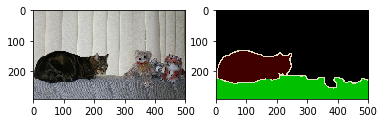

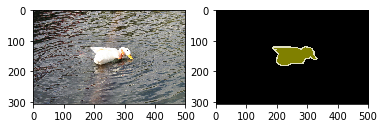

In [7]:
print(train_segmentations_raw[0].shape)
plot_ndarray(40, train_features_raw, train_segmentations_raw)
plot_ndarray(1, validation_features_raw, validation_segmentations_raw)

In [8]:
def convert_and_resize(data):
    converted_data = []
    for image in data:
        img = image.asnumpy()
        img = resize(img, (input_width, input_height)).astype('float32')
        converted_data.append(img)
    return np.array(converted_data)

train_features_resized = convert_and_resize(train_features_raw)
train_segmentations_resized = convert_and_resize(train_segmentations_raw)

validation_features_resized = convert_and_resize(validation_features_raw)
validation_segmentations_resized = convert_and_resize(validation_segmentations_raw)

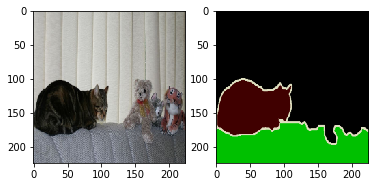

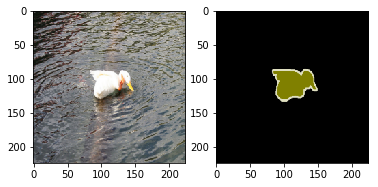

In [9]:
plot_pair(40, train_features_resized, train_segmentations_resized)
plot_pair(1, validation_features_resized, validation_segmentations_resized)

In [10]:
colormap2label = nd.zeros(256 ** 3)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

def voc_label_indices(colormap, colormap2label):
    colormap = colormap.astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [11]:
def getSegmentationArr( img , nClasses ,  width , height  ):
    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]
    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    return seg_labels

def get_segmentation_labels(segmentations):
    seg_labels = []
    for image in segmentations:
        seg_label = np.zeros((  224 , 224  , len(VOC_CLASSES) ))
        img = voc_label_indices(image, colormap2label)
        img_stacked = np.dstack([img.asnumpy(), img.asnumpy(), img.asnumpy()])
        img_mod = getSegmentationArr (img_stacked, n_classes, 224, 224)
        seg_labels.append(img_mod)
    return seg_labels
        
train_seg_labels = get_segmentation_labels(train_segmentations_raw)
val_seg_labels = get_segmentation_labels(validation_segmentations_raw)

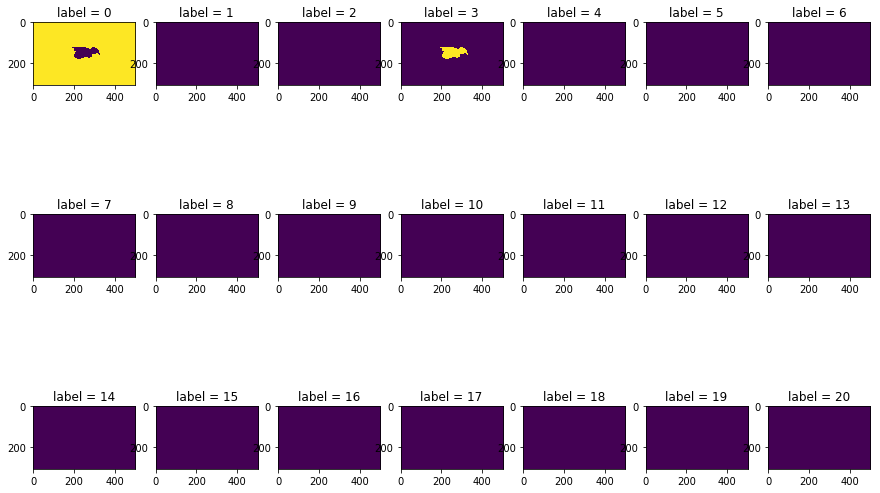

In [12]:
# Plot segmentations
img = voc_label_indices(train_segmentations_raw[1], colormap2label).asnumpy()
# img = train_seg_labels[0]
mi, ma = 0, 20
n_classes_plot = 21
fig = plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes_plot/3,k+1)
    ax.imshow((img == k)*1.0)
    ax.set_title("label = {}".format(k))

# Develop deep learning FCN model
##### It deplicates VGG16 net by discarding the final classifier layer and convert all fully connected layers to convolutions.

In [ ]:
## Import usual libraries
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd 
warnings.filterwarnings("ignore")

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.95
# config.gpu_options.visible_device_list = "0" 
# set_session(tf.Session(config=config))   


In [13]:
## location of VGG weights
VGG_Weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
def FCN8( nClasses,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) 
    ## is operated 5 times,which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', 
               data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', 
               data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1',
               data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2',
               data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1',
               data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2',
               data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3',
               data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1',
               data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2',
               data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3',
               data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1',
               data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2',
               data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3',
               data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    #x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fc1')(x)
    # <--> o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(4096, activation='relu', name='fc2')(x)
    # <--> o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)   
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(1000 , activation='softmax', name='predictions')(x)
    # <--> o = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    
    vgg  = Model(  img_input , pool5  )
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", 
                 data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7",
                 data_format=IMAGE_ORDERING))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same',
                       name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) ,
                                 use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

model = FCN8(nClasses     = n_classes,  
             input_height = input_height, 
             input_width  = input_width)
model.summary()

In [ ]:
from keras import optimizers

sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist1 = model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=1,epochs=1,verbose=2)

In [ ]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()